In [221]:
import numpy as np
import matplotlib.pyplot as plt
from read_simulation_data.get_mpi_info import get_mpi_info
from read_simulation_data.get_background_variable import get_background_variable
from read_simulation_data.get_foreground_variable import get_foreground_variable
from read_simulation_data.get_info import get_info
import h5py
from matplotlib.animation import FuncAnimation
import astropy.units as u

R_SUN = 6.957e10

In [15]:
DATA_FOLDER = "/mn/stornext/d10/data/tabjone/data/"

In [193]:
def get_rhs(folder, snap_number, variable_key):
    # Get the number of processes
    num_processes = get_mpi_info(folder+'mpi_info.h5')

    # Variable from all processes
    variable = []

    with h5py.File(f'{folder}snap{snap_number}_{0}.h5', 'r') as f:
        t = np.array(f['grid_info/t'])
        nz_ghost = np.array(f['grid_info/nz_ghost'])

    for i in range(num_processes):
        with h5py.File(f'{folder}rhs/rhs{snap_number}_{i}.h5', 'r') as f:
            dataset = f[f'rhs/{variable_key}']

            process_variable = np.array(dataset)
            variable.append(process_variable)
    
    # Concatenating the data for each variable
    variable = np.concatenate(variable, axis=0)
    
    return variable, t

In [202]:


manual_sum = pressure + advection + viscosity
t

array(500001.96969882)

In [265]:
def plot_rhs_column(RUN_NAME, snap, column, fig):
    ax = fig.add_subplot(111)

    pressure, t = get_rhs(DATA_FOLDER+RUN_NAME, snap-1, "pressure")
    advection, _ = get_rhs(DATA_FOLDER+RUN_NAME, snap-1, "advection")
    rhs, _ = get_rhs(DATA_FOLDER+RUN_NAME, snap-1, "rhs")
    viscosity, _ = get_rhs(DATA_FOLDER+RUN_NAME, snap-1, "viscosity")
    r, _ = get_background_variable(DATA_FOLDER+RUN_NAME, "r")
    r = r[2:-2]

    ax.plot(advection[column], r/R_SUN, label=r"$[-(v\cdot\nabla)v]_x$", )
    ax.plot(pressure[column], r/R_SUN, label=r"$[-1/\rho_0\nabla p]_x$")
    ax.plot(viscosity[column], r/R_SUN, label=r"$[\nabla\cdot\Pi]_x$", linestyle="--")
    ax.plot(rhs[column], r/R_SUN, label=r"RHS", linestyle=":", color="red")

    hours, remainder = divmod(t, 3600)
    minutes, seconds = divmod(remainder, 60)
    milliseconds = int((seconds - int(seconds)) * 1000)
    seconds = int(seconds)
    hours = int(hours)

    ax.set_xlabel("Value")
    ax.set_ylabel("Radius")
    ax.legend(loc="upper left")
    ax.set_title(f"Column {column} at t = {hours}h {minutes:.0f}m {seconds:.0f}s {milliseconds:.0f}ms")

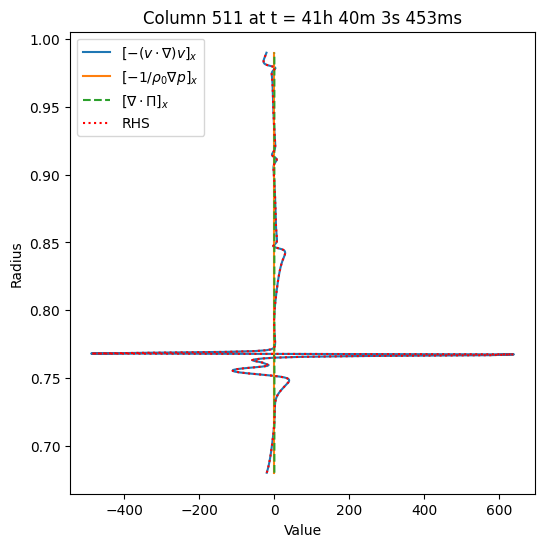

In [268]:
fig = plt.figure(figsize=(6, 6))
plot_rhs_column(RUN_NAME, 151, 511, fig)

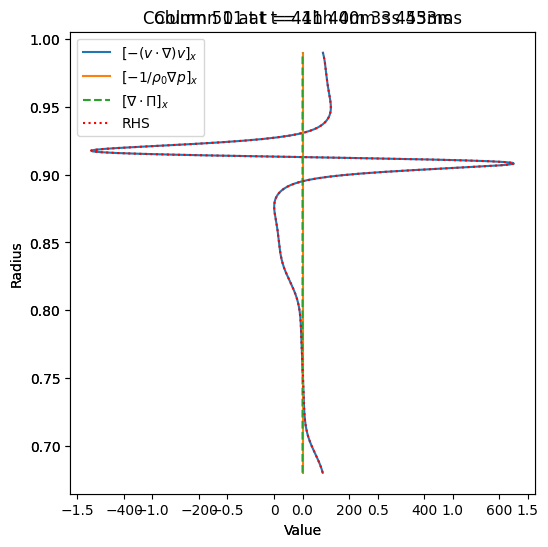

In [269]:
def animate_columns(RUN_NAME, snap, save_name, fps=4, save_interval=10, anim_interval=250):

    fig = plt.figure(figsize=(6, 6))  # Create a figure

    constants_dict, global_params_dict, grid_info_dict = get_info(DATA_FOLDER+RUN_NAME)
    num_cols = grid_info_dict['ny'][0]


    def init_animation():
        plot_rhs_column(RUN_NAME, snap, 0, fig)

    def update_animation(column_nr):
        """Update the plots for each frame."""
        for ax in fig.get_axes():
            ax.clear()  # Clear previous data
        fig.clear()
        plot_rhs_column(RUN_NAME, snap, column_nr, fig)

    anim = FuncAnimation(fig, update_animation, interval=anim_interval, frames=range(0,num_cols, save_interval), init_func=init_animation)

    anim.save(save_name, writer='ffmpeg', fps=fps, extra_args=['-vcodec', 'libx264'])

RUN_NAME = "test_print_column_dy_change_central_3/"
animate_columns(RUN_NAME, 151, "test_3.mp4", fps=5, save_interval=1, anim_interval=250)